In [76]:
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.applications import VGG16, Xception, ResNet50, InceptionResNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pathlib import Path

In [154]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [79]:
# Input
DATA_DIR = Path('/scratch/imb/Andrew/HEMnet')
TRAIN_DIR = DATA_DIR.joinpath('train_dataset_10x_13_12_19_strict/tiles_10x')
VAL_DIR = DATA_DIR.joinpath('gold_standards/1794_T/tiles_10x')

# Output

In [80]:
TRAIN_CANCER_DIR = TRAIN_DIR.joinpath('cancer')
TRAIN_NON_CANCER_DIR = TRAIN_DIR.joinpath('non-cancer')
VAL_CANCER_DIR = VAL_DIR.joinpath('cancer')
VAL_NON_CANCER_DIR = VAL_DIR.joinpath('non-cancer')

In [81]:
print('Training cancer images: ', len(list(TRAIN_CANCER_DIR.glob('*jpeg'))))
print('Training non-cancer images: ', len(list(TRAIN_NON_CANCER_DIR.glob('*jpeg'))))
print('Validation cancer images: ', len(list(VAL_CANCER_DIR.glob('*jpeg'))))
print('Validation non-cancer images: ', len(list(VAL_NON_CANCER_DIR.glob('*jpeg'))))

Training cancer images:  2979
Training non-cancer images:  3315
Validation cancer images:  1021
Validation non-cancer images:  724


In [164]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range = 360,
    horizontal_flip = True,
    vertical_flip = True)
val_datagen = ImageDataGenerator(rescale=1./255)

In [165]:
#TARGET_SIZE = (299, 299)
TARGET_SIZE = (150, 150)
BATCH_SIZE = 512

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    classes = ['cancer','non-cancer'],
    target_size = TARGET_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'binary')

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    classes = ['cancer','non-cancer'],
    target_size = TARGET_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'binary',
    shuffle = False)

Found 6294 images belonging to 2 classes.
Found 1745 images belonging to 2 classes.


In [166]:
num_of_val_samples = 1745

In [167]:
# xception_base = Xception(weights = 'imagenet', include_top = False)
# x = xception_base.output
# features = layers.GlobalMaxPooling2D()(x)

# conv_base = Model(xception_base.input, features)

In [97]:
conv_base = VGG16(weights = 'imagenet', include_top = False, input_shape = (150, 150, 3))

58892288/58889256 [==============================] - 6s 0us/step


In [120]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [99]:
conv_base.output_shape

(None, 4, 4, 512)

In [168]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [169]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [170]:
print('This is the number of trainable weights '
         'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 4


In [171]:
conv_base.trainable = False

In [172]:
print('This is the number of trainable weights '
          'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [173]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

# model.compile(loss='binary_crossentropy',
#               optimizer=optimizers.Adam(),
#               metrics=['acc'])

In [175]:
history = model.fit_generator(
    train_generator,
    epochs = 30,
    steps_per_epoch = 20,
    validation_data = val_generator)

Epoch 1/30
13/13 [==============================] - 34s 3s/step - loss: 0.5208 - acc: 0.7915 - val_loss: 0.7336 - val_acc: 0.5582
Epoch 2/30
13/13 [==============================] - 30s 2s/step - loss: 0.4114 - acc: 0.8335 - val_loss: 0.7044 - val_acc: 0.5851
Epoch 3/30
13/13 [==============================] - 30s 2s/step - loss: 0.3560 - acc: 0.8568 - val_loss: 0.6447 - val_acc: 0.6395
Epoch 4/30
13/13 [==============================] - 30s 2s/step - loss: 0.3156 - acc: 0.8740 - val_loss: 0.5995 - val_acc: 0.6946
Epoch 5/30
13/13 [==============================] - 30s 2s/step - loss: 0.2927 - acc: 0.8853 - val_loss: 0.5655 - val_acc: 0.7370
Epoch 6/30
13/13 [==============================] - 30s 2s/step - loss: 0.2772 - acc: 0.8869 - val_loss: 0.4910 - val_acc: 0.7862
Epoch 7/30
13/13 [==============================] - 30s 2s/step - loss: 0.2634 - acc: 0.8972 - val_loss: 0.4890 - val_acc: 0.7868
Epoch 8/30
13/13 [==============================] - 30s 2s/step - loss: 0.2531 - acc: 0.90

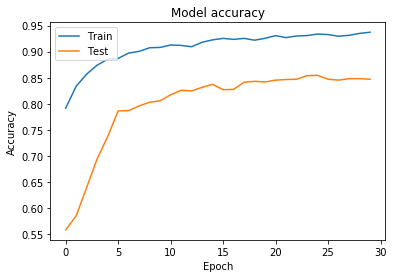

In [176]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

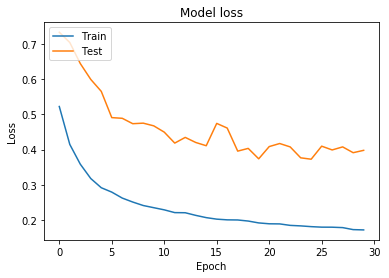

In [177]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

(array([751., 174.,  94.,  81.,  63.,  63.,  70.,  75., 121., 253.]),
 array([1.69575214e-05, 9.98339325e-02, 1.99650908e-01, 2.99467883e-01,
        3.99284858e-01, 4.99101833e-01, 5.98918808e-01, 6.98735783e-01,
        7.98552758e-01, 8.98369732e-01, 9.98186707e-01]),
 <a list of 10 Patch objects>)

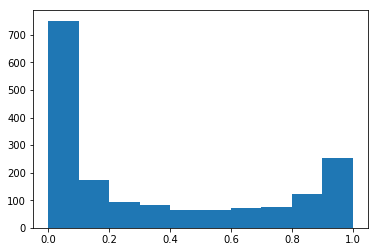

In [178]:
Y_pred = model.predict_generator(val_generator, num_of_val_samples // BATCH_SIZE + 1)
plt.hist(Y_pred)

In [179]:
val_generator.class_indices

{'cancer': 0, 'non-cancer': 1}

In [180]:
y_pred = np.round(Y_pred)

In [181]:
np.unique(y_pred, return_counts = True)

(array([0., 1.], dtype=float32), array([1164,  581]))

In [182]:
cm = confusion_matrix(val_generator.classes, y_pred)
cm

array([[959,  62],
       [205, 519]])

In [183]:
def plot_confusion_matrix(cm, classes=None):
    #Normalise Confusion Matrix by dividing each value by the sum of that row
    cm = cm.astype('float')/cm.sum(axis = 1)[:, np.newaxis]
    print(cm)
    #Make DataFrame from Confusion Matrix and classes
    cm_df = pd.DataFrame(cm, index = classes, columns = classes)
    #Display Confusion Matrix 
    plt.figure(figsize = (4,4), dpi = 300)
    cm_plot = sns.heatmap(cm_df, vmin = 0, vmax = 1, annot = True, fmt = '.2f', cmap = 'Blues', square = True)
    plt.title('Confusion Matrix', fontsize = 12)
    #Display axes labels
    plt.ylabel('True label', fontsize = 12)
    plt.xlabel('Predicted label', fontsize = 12)
    plt.savefig('./age_confusion_matrix_combine.pdf')
    plt.tight_layout()
    return cm_plot

[[0.93927522 0.06072478]
 [0.28314917 0.71685083]]


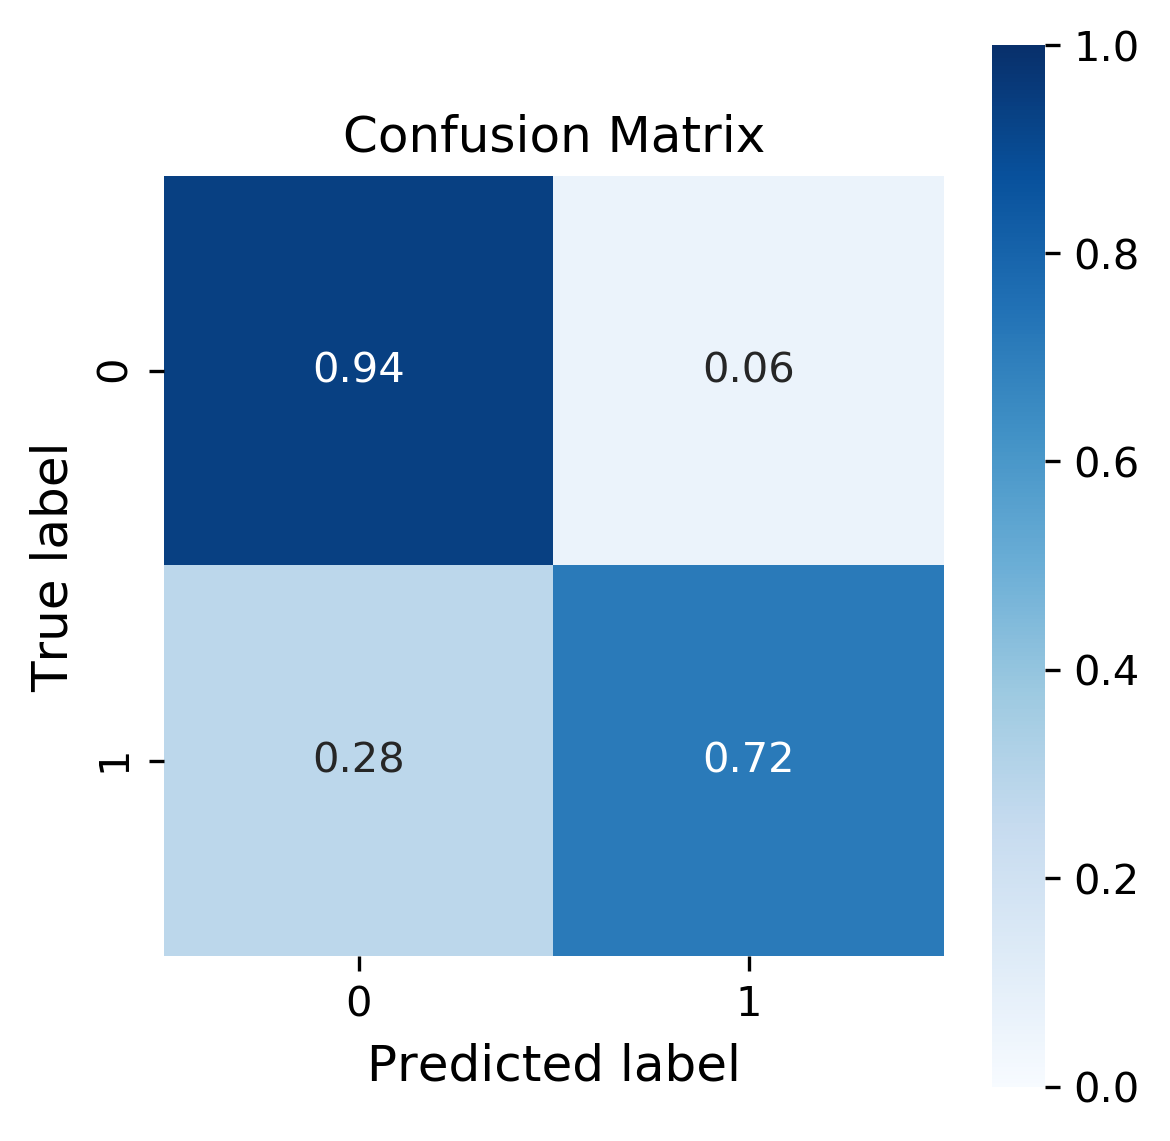

In [184]:
plot_confusion_matrix(cm)